# 1083 Albumin Initial ML

### By: Ian Weimer

## Imports

In [12]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [13]:
df = pd.read_csv('K85_matched_2.csv')

In [14]:
df.LOS_days.describe()

count    6318.000000
mean        9.361549
std         9.480048
min         0.000000
25%         3.058333
50%         6.202778
75%        12.211285
max        53.249722
Name: LOS_days, dtype: float64

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [15]:
df[df['albumin_24hrs'] == 1].LOS_days.describe()

count    3159.000000
mean       11.544970
std        10.512175
min         0.054167
25%         4.094792
50%         8.156944
75%        15.551962
max        53.249722
Name: LOS_days, dtype: float64

In [16]:
df[df['albumin_24hrs'] == 0].LOS_days.describe()

count    3159.000000
mean        7.178128
std         7.728361
min         0.000000
25%         2.457980
50%         4.860417
75%         8.915625
max        52.900000
Name: LOS_days, dtype: float64

## Convert LOS_days to Categorical

In [17]:
# Calculate Tertiles

q1 = df['LOS_days'].quantile(q=(1/3))
q2 = df['LOS_days'].quantile(q=(2/3))
print(q1)
print(q2)

4.005324074074075
9.502943672839496


In [18]:
# bin the LOS_days var

LOS = df['LOS_days']
m = max(LOS)

bins = [0, 4.28, 10.08, m]
labels=[0, 1, 2]

# 0 - Low/Short Length of Stay
# 1 - Medium Length of Stay
# 2 - High/Long Length of Stay

df['LOS_days'] = pd.cut(LOS, bins=bins, labels=labels, include_lowest=True)

In [19]:
df['LOS_days'].value_counts()

0    2275
1    2070
2    1973
Name: LOS_days, dtype: int64

In [20]:
df.head()

encounterid  ICU  Cirrhosis  CCI  qSOFA  SEWS  \
0  2dc21f88-780f-49ff-8869-9b859454cb25    1          0    0      1     1   
1  b41e918b-0767-41a8-97bd-cebb56dadb92    1          0    1      3     5   
2  c51a4a13-b8e9-4c35-bc11-c3443f668b06    1          0    0      1     2   
3  92e7d39f-a88c-48af-a64d-d7ad52cd08d0    0          1    4      1     1   
4  d2ea8946-63ac-46fc-b0cc-c41a31f2dda4    0          1    3      1     1   

   LVR  propensity_score  propensity_logit  albumin_24hrs  \
0    0          0.710132          0.896024              1   
1    0          0.975129          3.668856              1   
2    0          0.770494          1.211100              1   
3    0          0.886667          2.057142              1   
4    0          0.851459          1.746093              1   

                               personid LOS_days  90_day_mortality  \
0  0101df2c-9e73-43f3-8a86-3804062428ea        0                 0   
1  020382ec-fec4-4cfd-90a8-9648a9908768        0                 0   
2  2659d580-6afc-4e49-b02c-cfdb6b417d3a        2                 0   
3  28ca1cb5-ba48-49d2-9ea6-402605244827        1                 0   
4  37dd3925-89b8-4f2f-ba94-ea913e692a00        1                 0   

   90_day_readmission  hospital_free_days  albumin_timing  albumin  
0                 0.0                  87             2.0        1  
1                 1.0                  68             2.0        1  
2                 0.0                  29             1.0        1  
3                 1.0                  12             2.0        1  
4                 0.0                  84             2.0        1

In [21]:
df.shape

(6318, 17)

In [22]:
df.drop(columns=['propensity_score', 'propensity_logit', 'encounterid', 'personid', 'albumin', 'albumin_timing'], inplace=True)

In [23]:
df.drop(columns=['90_day_mortality', '90_day_readmission', 'hospital_free_days'], inplace=True)

In [24]:
df.head()

ICU  Cirrhosis  CCI  qSOFA  SEWS  LVR  albumin_24hrs LOS_days
0    1          0    0      1     1    0              1        0
1    1          0    1      3     5    0              1        0
2    1          0    0      1     2    0              1        2
3    0          1    4      1     1    0              1        1
4    0          1    3      1     1    0              1        1

In [25]:
# remove variables

# df.drop(columns=['anemia_status', 'SAPS', 'qSOFA', 'mass_transfusion'], inplace=True)

In [26]:
df.describe()

ICU    Cirrhosis          CCI        qSOFA         SEWS  \
count  6318.000000  6318.000000  6318.000000  6318.000000  6318.000000   
mean      0.311808     0.395695     3.550649     0.778411     1.707819   
std       0.463268     0.489038     2.802939     0.809334     1.932723   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     1.000000     0.000000     0.000000   
50%       0.000000     0.000000     3.000000     1.000000     1.000000   
75%       1.000000     1.000000     5.000000     1.000000     3.000000   
max       1.000000     1.000000    15.000000     3.000000    14.000000   

               LVR  albumin_24hrs  
count  6318.000000     6318.00000  
mean      0.185977        0.50000  
std       0.389119        0.50004  
min       0.000000        0.00000  
25%       0.000000        0.00000  
50%       0.000000        0.50000  
75%       0.000000        1.00000  
max       1.000000        1.00000

In [27]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Modeling

In [28]:
# establish target feature, LOS_days, as y feature
y = df['LOS_days']
# drop target feature from features dataframe
X = df.drop(columns = ['LOS_days'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [29]:
cols

Index(['ICU', 'Cirrhosis', 'CCI', 'qSOFA', 'SEWS', 'LVR', 'albumin_24hrs'], dtype='object')

## Standardize Data

In [30]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [31]:
X.head()

ICU  Cirrhosis  CCI  qSOFA  SEWS  LVR  albumin_24hrs
0    1          0    0      1     1    0              1
1    1          0    1      3     5    0              1
2    1          0    0      1     2    0              1
3    0          1    4      1     1    0              1
4    0          1    3      1     1    0              1

## Train Test Split

In [32]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [33]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

Feature: ICU Score: -0.49357
Feature: Cirrhosis Score: -0.03061
Feature: CCI Score: -0.05346
Feature: qSOFA Score: -0.16267
Feature: SEWS Score: -0.01263
Feature: LVR Score: -0.30976
Feature: albumin_24hrs Score: -0.60932


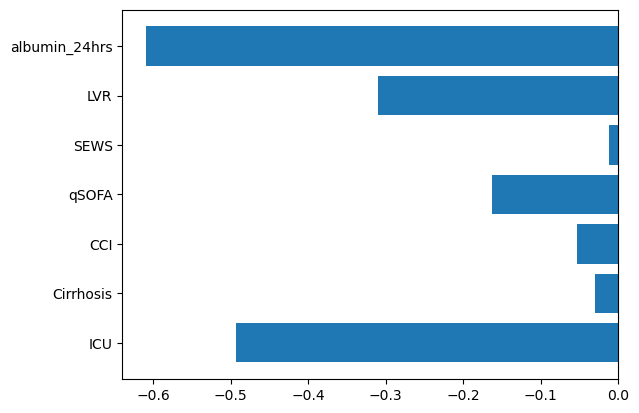

In [34]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

               Importance
SEWS             0.987445
Cirrhosis        0.969858
CCI              0.947943
qSOFA            0.849869
LVR              0.733623
ICU              0.610444
albumin_24hrs    0.543720


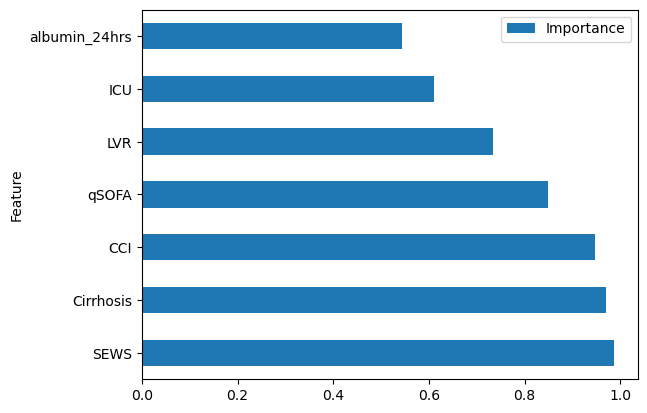

In [35]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [36]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [37]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1183  209  413]
 [ 815  283  550]
 [ 524  218  859]]


In [38]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.47      0.66      0.55      1805
           1       0.40      0.17      0.24      1648
           2       0.47      0.54      0.50      1601

    accuracy                           0.46      5054
   macro avg       0.45      0.45      0.43      5054
weighted avg       0.45      0.46      0.43      5054



In [39]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[313  50 107]
 [212  83 127]
 [119  53 200]]


In [40]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.49      0.67      0.56       470
           1       0.45      0.20      0.27       422
           2       0.46      0.54      0.50       372

    accuracy                           0.47      1264
   macro avg       0.46      0.47      0.44      1264
weighted avg       0.47      0.47      0.45      1264



## 1: Decision Tree 

In [41]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.18581
Feature: Cirrhosis Score: 0.01687
Feature: CCI Score: 0.16068
Feature: qSOFA Score: 0.12546
Feature: SEWS Score: 0.14697
Feature: LVR Score: 0.02128
Feature: albumin_24hrs Score: 0.34292


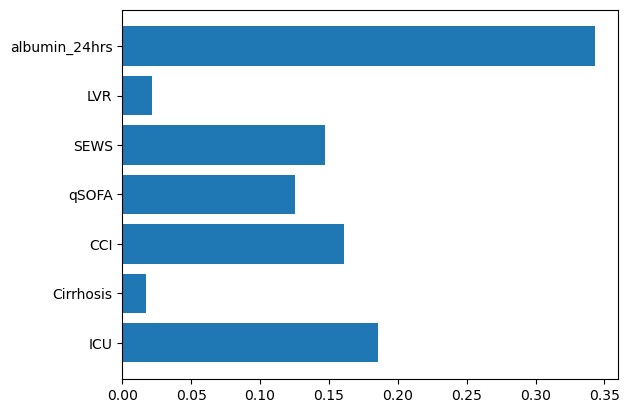

In [42]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [43]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [44]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[998 407 400]
 [570 573 505]
 [344 387 870]]


In [45]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.52      0.55      0.54      1805
           1       0.42      0.35      0.38      1648
           2       0.49      0.54      0.52      1601

    accuracy                           0.48      5054
   macro avg       0.48      0.48      0.48      5054
weighted avg       0.48      0.48      0.48      5054



In [46]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[262 113  95]
 [161 137 124]
 [ 80  96 196]]


In [47]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.52      0.56      0.54       470
           1       0.40      0.32      0.36       422
           2       0.47      0.53      0.50       372

    accuracy                           0.47      1264
   macro avg       0.46      0.47      0.46      1264
weighted avg       0.46      0.47      0.47      1264



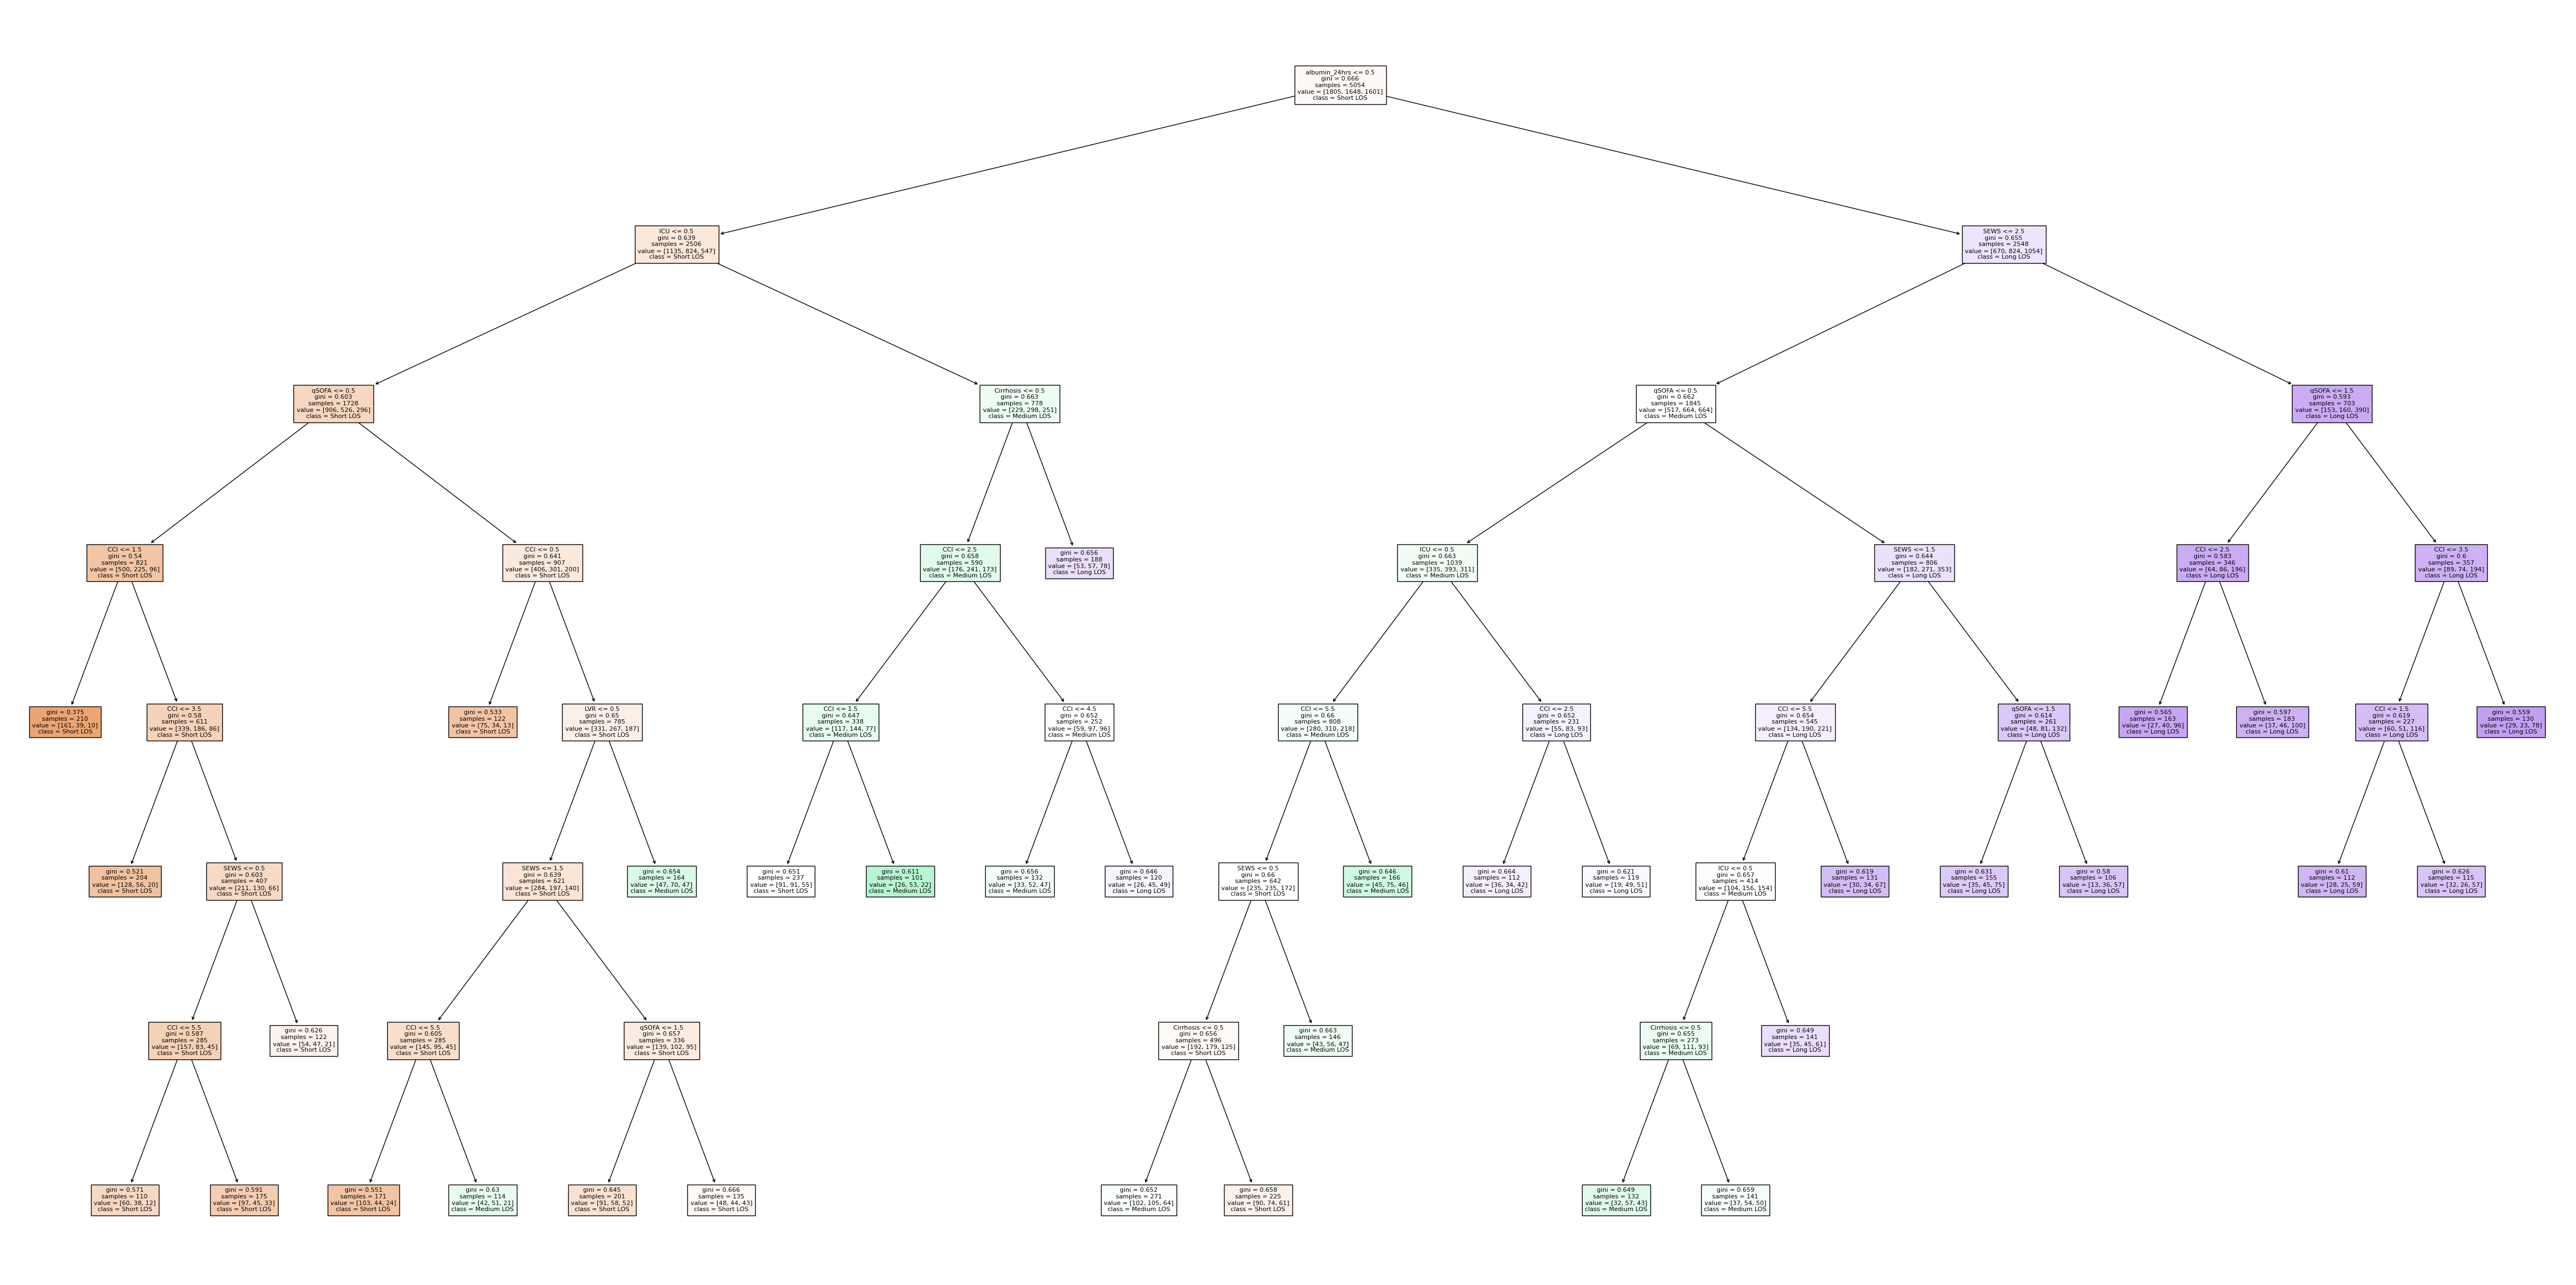

In [48]:
feature_names = X_train.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [49]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('LOS_DT_D7_PSM_MATCHED_3.png')

True

## Random Forest

In [50]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [51]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [52]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1050  368  387]
 [ 635  521  492]
 [ 375  394  832]]


In [53]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.51      0.58      0.54      1805
           1       0.41      0.32      0.36      1648
           2       0.49      0.52      0.50      1601

    accuracy                           0.48      5054
   macro avg       0.47      0.47      0.47      5054
weighted avg       0.47      0.48      0.47      5054



In [54]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[278  89 103]
 [169 142 111]
 [ 92  91 189]]


In [55]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.52      0.59      0.55       470
           1       0.44      0.34      0.38       422
           2       0.47      0.51      0.49       372

    accuracy                           0.48      1264
   macro avg       0.48      0.48      0.47      1264
weighted avg       0.48      0.48      0.48      1264



Feature: ICU Score: 0.17394
Feature: Cirrhosis Score: 0.02246
Feature: CCI Score: 0.08744
Feature: qSOFA Score: 0.14555
Feature: SEWS Score: 0.13551
Feature: LVR Score: 0.03253
Feature: albumin_24hrs Score: 0.40256


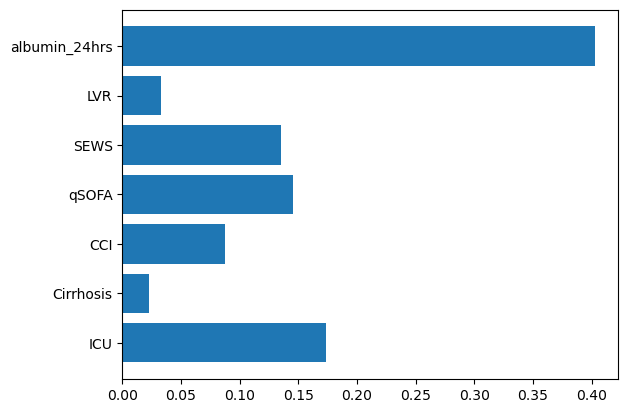

In [56]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()